# STEP1:Create a normalized database (3NF).

## Utility Functions for Database Creation

In [6]:
import sqlite3
from sqlite3 import Error
import csv

# Utility: Create connection
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")  # Enable foreign key constraints
    except Error as e:
        print(e)
    return conn

# Utility: Create table
def create_table(conn, create_table_sql, drop_table_name=None):
    if drop_table_name:
        try:
            c = conn.cursor()
            c.execute(f"DROP TABLE IF EXISTS {drop_table_name}")
        except Error as e:
            print(e)
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

# Utility: Execute SQL
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows

## Create the Customer Table

In [ ]:
def create_customers_table(data_filename, normalized_database_filename):
    customers_set = set()

    # Extract customer-specific fields from the data
    with open(data_filename, 'r') as file:
        reader = csv.reader(file, delimiter=';')
        next(reader)  # Skip header row
        for row in reader:
            age, job, marital, education, default, housing, loan = row[0:7]
            customers_set.add((int(age), job, marital, education, default, housing, loan))

    customers_list = list(customers_set)

    # SQL to create the Customers table
    create_customers_sql = """
    CREATE TABLE Customers (
        CustomerID INTEGER PRIMARY KEY AUTOINCREMENT,
        Age INTEGER NOT NULL,
        Job TEXT NOT NULL,
        Marital_Status TEXT NOT NULL,
        Education TEXT NOT NULL,
        Default_Status TEXT NOT NULL,
        Housing TEXT NOT NULL,
        Loan TEXT NOT NULL
    );
    """

    try:
        # Create the table and populate data
        with create_connection(normalized_database_filename) as conn:
            create_table(conn, create_customers_sql, drop_table_name="Customers")
            cursor = conn.cursor()
            cursor.executemany("INSERT INTO Customers (Age, Job, Marital_Status, Education, Default_Status, Housing, Loan) VALUES (?, ?, ?, ?, ?, ?, ?)", customers_list)
    except sqlite3.Error as e:
        print(f"Database error occurred: {e}")
        raise

## Create the Macroeconomic Table

In [11]:
def create_macroeconomic_table(data_filename, normalized_database_filename):
    macroeconomic_set = set()

    # Extract macroeconomic fields from the data
    with open(data_filename, 'r') as file:
        reader = csv.reader(file, delimiter=';')
        next(reader)  # Skip header row
        for row in reader:
            emp_var_rate, cons_price_idx, cons_conf_idx, euribor3m, nr_employed = row[15:20]
            macroeconomic_set.add((float(emp_var_rate), float(cons_price_idx), float(cons_conf_idx), float(euribor3m), float(nr_employed)))

    macroeconomic_list = list(macroeconomic_set)

    # SQL to create the Macroeconomic table
    create_macroeconomic_sql = """
    CREATE TABLE Macroeconomic (
        MacroID INTEGER PRIMARY KEY AUTOINCREMENT,
        EmpVarRate REAL NOT NULL,
        ConsPriceIdx REAL NOT NULL,
        ConsConfIdx REAL NOT NULL,
        Euribor3m REAL NOT NULL,
        NrEmployed REAL NOT NULL
    );
    """

    try:
        # Create the table and populate data
        with create_connection(normalized_database_filename) as conn:
            create_table(conn, create_macroeconomic_sql, drop_table_name="Macroeconomic")
            cursor = conn.cursor()
            cursor.executemany("INSERT INTO Macroeconomic (EmpVarRate, ConsPriceIdx, ConsConfIdx, Euribor3m, NrEmployed) VALUES (?, ?, ?, ?, ?)", macroeconomic_list)
    except sqlite3.Error as e:
        print(f"Database error occurred: {e}")
        raise

## Create the Campaigns Table

In [14]:
def create_campaigns_table(data_filename, normalized_database_filename):
    macroeconomic_mapping = {}

    # Step 1: Map macroeconomic features to MacroID
    with create_connection(normalized_database_filename) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT * FROM Macroeconomic")
        macroeconomic_records = cursor.fetchall()

        for record in macroeconomic_records:
            macro_id = record[0]
            macro_key = tuple(record[1:])  # Use all macroeconomic fields as the key
            macroeconomic_mapping[macro_key] = macro_id

    # Step 2: Extract campaign-specific fields from the data
    campaigns_set = set()
    with open(data_filename, 'r') as file:
        reader = csv.reader(file, delimiter=';')
        next(reader)  # Skip header row
        for row in reader:
            contact, month, day_of_week, duration, campaign, pdays, previous, poutcome = row[7:15]
            emp_var_rate, cons_price_idx, cons_conf_idx, euribor3m, nr_employed = row[15:20]
            macro_key = (float(emp_var_rate), float(cons_price_idx), float(cons_conf_idx), float(euribor3m), float(nr_employed))
            macro_id = macroeconomic_mapping.get(macro_key)

            if macro_id is not None:  # Only add campaigns with a valid MacroID
                campaigns_set.add((contact, month, day_of_week, int(duration), int(campaign), int(pdays), int(previous), poutcome, macro_id))

    campaigns_list = list(campaigns_set)

    # Step 3: Create the Campaigns table
    create_campaigns_sql = """
    CREATE TABLE Campaigns (
        CampaignID INTEGER PRIMARY KEY AUTOINCREMENT,
        Contact TEXT NOT NULL,
        Month TEXT NOT NULL,
        DayOfWeek TEXT NOT NULL,
        Duration INTEGER NOT NULL,
        Campaign INTEGER NOT NULL,
        Pdays INTEGER NOT NULL,
        Previous INTEGER NOT NULL,
        Poutcome TEXT NOT NULL,
        MacroID INTEGER NOT NULL,
        FOREIGN KEY (MacroID) REFERENCES Macroeconomic(MacroID)
    );
    """

    try:
        # Step 4: Populate data into the Campaigns table
        with create_connection(normalized_database_filename) as conn:
            create_table(conn, create_campaigns_sql, drop_table_name="Campaigns")
            cursor = conn.cursor()
            cursor.executemany(
                "INSERT INTO Campaigns (Contact, Month, DayOfWeek, Duration, Campaign, Pdays, Previous, Poutcome, MacroID) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)",
                campaigns_list
            )
            conn.commit()
    except sqlite3.Error as e:
        print(f"Database error occurred: {e}")
        raise


## Mapping Customer Details to CustomerID

In [17]:
def create_customer_to_customer_id_dict(normalized_database_filename):
    customer_to_customer_id_dict = {}

    try:
        # Connect to the database and fetch all customer records
        with create_connection(normalized_database_filename) as conn:
            cursor = conn.cursor()
            cursor.execute("SELECT CustomerID, Age, Job, Marital_Status, Education, Default_Status, Housing, Loan FROM Customers")
            customers = cursor.fetchall()

        # Create a dictionary mapping customer attributes to CustomerID
        for customer in customers:
            customer_id = customer[0]
            customer_key = tuple(customer[1:])
            customer_to_customer_id_dict[customer_key] = customer_id

    except sqlite3.Error as e:
        print(f"Database error occurred while creating customer-to-customer ID mapping: {e}")
        raise

    return customer_to_customer_id_dict


## Mapping Campaign Details to CampaignID

In [20]:
def create_campaign_to_campaign_id_dict(normalized_database_filename):
    campaign_to_campaign_id_dict = {}

    try:
        # Connect to the database and fetch all campaign records
        with create_connection(normalized_database_filename) as conn:
            cursor = conn.cursor()
            cursor.execute("SELECT CampaignID, Contact, Month, DayOfWeek, Duration, Campaign, Pdays, Previous, Poutcome FROM Campaigns")
            campaigns = cursor.fetchall()

        # Create a dictionary mapping campaign attributes to CampaignID
        for campaign in campaigns:
            campaign_id = campaign[0]
            campaign_key = tuple(campaign[1:])
            campaign_to_campaign_id_dict[campaign_key] = campaign_id

    except sqlite3.Error as e:
        print(f"Database error occurred while creating campaign-to-campaign ID mapping: {e}")
        raise

    return campaign_to_campaign_id_dict

## Create the Outcomes Table

In [26]:
def create_outcomes_table(data_filename, normalized_database_filename):
    # Get mappings for Customers and Campaigns
    customers_mapping = create_customer_to_customer_id_dict(normalized_database_filename)
    campaigns_mapping = create_campaign_to_campaign_id_dict(normalized_database_filename)

    outcomes_list = []

    # Extract outcome-specific fields from the data
    with open(data_filename, 'r') as file:
        reader = csv.reader(file, delimiter=';')
        next(reader)  # Skip header row
        for row in reader:
            age, job, marital, education, default_status, housing, loan = row[0:7]
            contact, month, day_of_week, duration, campaign, pdays, previous, poutcome = row[7:15]
            subscribed = row[20]

            # Create keys to look up CustomerID and CampaignID
            customer_key = (int(age), job, marital, education, default_status, housing, loan)
            campaign_key = (contact, month, day_of_week, int(duration), int(campaign), int(pdays), int(previous), poutcome)

            # Get CustomerID and CampaignID from the mappings
            customer_id = customers_mapping[customer_key]
            campaign_id = campaigns_mapping[campaign_key]

            # Add the outcome record
            outcomes_list.append((customer_id, campaign_id, subscribed))

    # SQL to create the Outcomes table
    create_outcomes_sql = """
    CREATE TABLE Outcomes (
        OutcomeID INTEGER PRIMARY KEY AUTOINCREMENT,
        CustomerID INTEGER NOT NULL,
        CampaignID INTEGER NOT NULL,
        Subscribed TEXT NOT NULL,
        FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID),
        FOREIGN KEY (CampaignID) REFERENCES Campaigns(CampaignID)
    );
    """

    try:
        # Create the table and populate data
        with create_connection(normalized_database_filename) as conn:
            create_table(conn, create_outcomes_sql, drop_table_name="Outcomes")
            cursor = conn.cursor()
            cursor.executemany("INSERT INTO Outcomes (CustomerID, CampaignID, Subscribed) VALUES (?, ?, ?)", outcomes_list)
    except sqlite3.Error as e:
        print(f"Database error occurred: {e}")
        raise


## Exceute the Database Creation

In [31]:
normalized_db_file = "bank_marketing_normalized_3NF.db"
data_file = "bank-additional.csv"

create_customers_table(data_file, normalized_db_file)
create_macroeconomic_table(data_file, normalized_db_file)
create_campaigns_table(data_file, normalized_db_file)
create_outcomes_table(data_file, normalized_db_file)

## STEP 2: Write SQL join statement to fetch data from the database and into Pandas DataFrame.

In [5]:
import sqlite3
import pandas as pd

# File path for the database
db_filename = "bank_marketing_normalized_3NF.db"

# SQL Query to combine data from Customers, Campaigns, Macroeconomic, and Outcomes tables
sql_query = """
SELECT 
    c.Age, 
    c.Job, 
    c.Marital_Status, 
    c.Education, 
    c.Default_Status, 
    c.Housing, 
    c.Loan,
    ca.Contact, 
    ca.Month, 
    ca.DayOfWeek, 
    ca.Duration, 
    ca.Campaign, 
    ca.Pdays, 
    ca.Previous, 
    ca.Poutcome,
    m.EmpVarRate, 
    m.ConsPriceIdx, 
    m.ConsConfIdx, 
    m.Euribor3m, 
    m.NrEmployed,
    o.Subscribed
FROM 
    Outcomes o
JOIN 
    Customers c ON o.CustomerID = c.CustomerID
JOIN 
    Campaigns ca ON o.CampaignID = ca.CampaignID
JOIN 
    Macroeconomic m ON ca.MacroID = m.MacroID;
"""

# Function to fetch data from the database and load it into a Pandas DataFrame
def fetch_data_into_dataframe(db_file, query):
    try:
        # Connect to the database
        conn = sqlite3.connect(db_file)
        print("Database connection successful.")

        # Execute the query and load into a Pandas DataFrame
        df = pd.read_sql_query(query, conn)

        # Close the connection
        conn.close()

        print("Data loaded successfully into DataFrame.")
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None

# Fetch data and verify
dataframe = fetch_data_into_dataframe(db_filename, sql_query)

# Display the first few rows of the DataFrame
if dataframe is not None:
    print("First 5 rows of the DataFrame:")
    print(dataframe.head())
else:
    print("Failed to load data into DataFrame.")

Database connection successful.
Data loaded successfully into DataFrame.
First 5 rows of the DataFrame:
   Age          Job Marital_Status          Education Default_Status  Housing  \
0   30  blue-collar        married           basic.9y             no      yes   
1   39     services         single        high.school             no       no   
2   25     services        married        high.school             no      yes   
3   38     services        married           basic.9y             no  unknown   
4   47       admin.        married  university.degree             no      yes   

      Loan    Contact Month DayOfWeek  ...  Campaign  Pdays  Previous  \
0       no   cellular   may       fri  ...         2    999         0   
1       no  telephone   may       fri  ...         4    999         0   
2       no  telephone   jun       wed  ...         1    999         0   
3  unknown  telephone   jun       fri  ...         3    999         0   
4       no   cellular   nov       mon  ...  

In [6]:
print(dataframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             4119 non-null   int64  
 1   Job             4119 non-null   object 
 2   Marital_Status  4119 non-null   object 
 3   Education       4119 non-null   object 
 4   Default_Status  4119 non-null   object 
 5   Housing         4119 non-null   object 
 6   Loan            4119 non-null   object 
 7   Contact         4119 non-null   object 
 8   Month           4119 non-null   object 
 9   DayOfWeek       4119 non-null   object 
 10  Duration        4119 non-null   int64  
 11  Campaign        4119 non-null   int64  
 12  Pdays           4119 non-null   int64  
 13  Previous        4119 non-null   int64  
 14  Poutcome        4119 non-null   object 
 15  EmpVarRate      4119 non-null   float64
 16  ConsPriceIdx    4119 non-null   float64
 17  ConsConfIdx     4119 non-null   f

In [7]:
print(dataframe.describe())

               Age     Duration     Campaign        Pdays     Previous  \
count  4119.000000  4119.000000  4119.000000  4119.000000  4119.000000   
mean     40.113620   256.788055     2.537266   960.422190     0.190337   
std      10.313362   254.703736     2.568159   191.922786     0.541788   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   103.000000     1.000000   999.000000     0.000000   
50%      38.000000   181.000000     2.000000   999.000000     0.000000   
75%      47.000000   317.000000     3.000000   999.000000     0.000000   
max      88.000000  3643.000000    35.000000   999.000000     6.000000   

        EmpVarRate  ConsPriceIdx  ConsConfIdx    Euribor3m   NrEmployed  
count  4119.000000   4119.000000  4119.000000  4119.000000  4119.000000  
mean      0.083224     93.578834   -40.502743     3.619676  5166.444453  
std       1.563867      0.579407     4.595801     1.733973    73.648012  
min      -3.400000     92.201000   -5

In [8]:
# Check class distribution
print("Class Distribution of 'Subscribed':")
print(dataframe['Subscribed'].value_counts(normalize=True))  # Proportion
print(dataframe['Subscribed'].value_counts())  # Counts

Class Distribution of 'Subscribed':
Subscribed
no     0.890507
yes    0.109493
Name: proportion, dtype: float64
Subscribed
no     3668
yes     451
Name: count, dtype: int64


## STEP 3: Explore the data using yprofile and correlation matrix.<br> Make observations about features, distributions, capped values, and missing values. <br>Create a list of data cleanup tasks.

In [9]:
pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [10]:
from ydata_profiling import ProfileReport

profile = ProfileReport(dataframe,title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

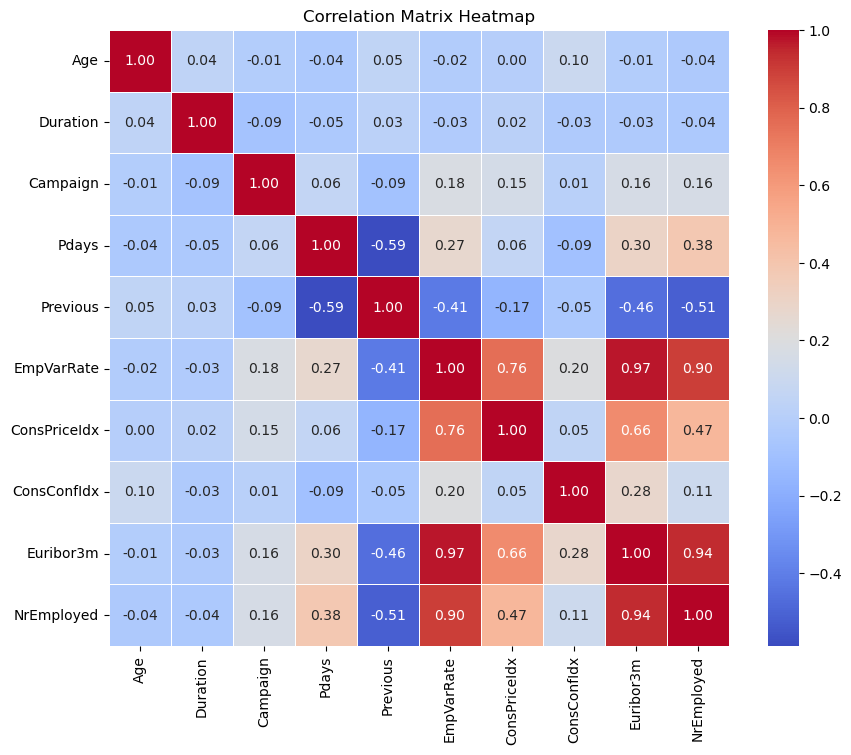

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

numerical_columns = dataframe.select_dtypes(include=['number'])

# Compute the correlation matrix for numerical columns
correlation_matrix = numerical_columns.corr()


plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")

# My Data Cleanup & Preprocessing Task List

### Handling "unknown" Categories
- I will keep “unknown” as a distinct category for now.
- If certain "unknown" categories occur very rarely, I may merge them with another category or just leave them as is, depending on further analysis.

### Creating Derived Features for Pdays/Previous
- I plan to convert `pdays == 999` into a binary feature, for example:
  - `was_not_previously_contacted = 1 if pdays == 999 else 0`.
- I will consider dropping or transforming `Previous` if it’s mostly zeros. Alternatively, I could retain it but note its limited variance.

### Addressing Highly Correlated Features
- Macroeconomic features (e.g., `EmpVarRate`, `ConsPriceIdx`, `ConsConfIdx`, `Euribor3m`, `NrEmployed`) are strongly correlated.
- After initial baseline modeling, I may use feature selection techniques (Experiment #4) or apply PCA (Experiment #5) to reduce redundancy and avoid overfitting.
- I might consider dropping or combining some highly correlated macro features if they do not contribute to better F1-scores.

### Scaling Numeric Features as Needed
- For models sensitive to scale (such as Logistic Regression or SVM), I will apply `StandardScaler` or `MinMaxScaler` to numeric features.
- If `Duration` or other numeric features are significantly skewed, I will consider applying a log transformation (`np.log1p`) to stabilize their distributions.

### Encoding Categorical Variables
- I will apply `OneHotEncoder` to all categorical features: `Job`, `Marital_Status`, `Education`, `Contact`, `Month`, `DayOfWeek`, `Poutcome`, `Housing`, `Loan`, and `Default_Status`.
- This ensures all categorical variables are converted into a numeric format suitable for machine learning algorithms.

### Stratification Decision
- Given the class imbalance in the target variable (`Subscribed`), I will stratify by `Subscribed` when performing the train/test split.
- By doing so, I can maintain the same class ratio in both the training and test sets, resulting in more reliable evaluation metrics.

## STEP4:<br>Explore the data to determine if you need to stratify it by some attribute when doing train/test split. <br> Perform the train/test split.

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# I will check the distribution of the target 'Subscribed' to confirm if it's imbalanced.
print(dataframe['Subscribed'].value_counts())

Subscribed
no     3668
yes     451
Name: count, dtype: int64


In [13]:
# Since I see an imbalance in the target classes (e.g., around 11% 'yes' and 89% 'no'),
# I will stratify by 'Subscribed' to ensure that both training and test sets 
# maintain the same proportion of classes.


X = dataframe.drop('Subscribed', axis=1)
y = dataframe['Subscribed']

# I will now perform the train/test split with stratification on the target variable.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# I want to confirm that the class distribution is similar in both training and test sets.
print("Train set 'Subscribed' distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set 'Subscribed' distribution:")
print(y_test.value_counts(normalize=True))

Train set 'Subscribed' distribution:
Subscribed
no     0.89044
yes    0.10956
Name: proportion, dtype: float64

Test set 'Subscribed' distribution:
Subscribed
no     0.890777
yes    0.109223
Name: proportion, dtype: float64


## Experiment #1: <br> Create a pipeline for preprocessing (StandardScaler, MinMaxScaler, LogTransformation, OneHotEncoding) and Logistic Regression. <br>Log F1-score/(TP,TN,FN,FP)  in MLFlow on DagsHub. – Cross validation 3/10 folds. <br>Results—mean/std of CV results and results on the whole training data – add in parameter hyper tuning

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import mlflow
import mlflow.sklearn

In [15]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=[object]).columns.tolist()

In [16]:
# Optional: log transform for skewed numeric feature (e.g., 'Duration')
def log_transform_duration(X):
    # If 'Duration' is a numeric feature and you want to log transform it
    if 'Duration' in numeric_features:
        X = X.copy()
        duration_idx = numeric_features.index('Duration')
        X[:, duration_idx] = np.log1p(X[:, duration_idx])
    return X

log_transformer = FunctionTransformer(log_transform_duration, validate=False)

In [17]:
# Numeric pipeline
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log_transform", log_transformer),  # Remove this step if not needed
    ("scaler", StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer
preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

In [18]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)

pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("clf", model)
])

# Define a custom F1 scorer with pos_label='yes'
f1_scorer = make_scorer(f1_score, pos_label='yes')

In [19]:
# Hyperparameter grid
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"]
}

# Use 10-fold CV for hyperparameter tuning
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, scoring=f1_scorer, cv=cv_10, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
cv_results = grid_search.cv_results_
mean_f1_10 = grid_search.best_score_
std_f1_10 = cv_results['std_test_score'][grid_search.best_index_]

print("Best Params (from 10-fold CV):", grid_search.best_params_)
print("10-fold CV Mean F1:", mean_f1_10, "CV Std F1:", std_f1_10)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log_transform',
                                                                                          FunctionTransformer(func=<function log_transform_duration at 0x17f452e80>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Durat...
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Job',
                                                                          'Marital_Status',
                                                                          'Education',
                                                                          'Default_Status',
                                                                          'Housing',
                                                                          'Loan',
                                                                          'Contact',
                                                                          'Month',
                                                                          'DayOfWeek',
                                                                          'Poutcome'])])),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2']},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=yes))

Best Params (from 10-fold CV): {'clf__C': 10, 'clf__penalty': 'l2'}
10-fold CV Mean F1: 0.5195771138303874 CV Std F1: 0.06365720731404442


In [20]:
# Evaluate on training and test sets
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

f1_train = f1_score(y_train, y_pred_train, pos_label='yes')
f1_test = f1_score(y_test, y_pred_test, pos_label='yes')

cm = confusion_matrix(y_test, y_pred_test, labels=['no', 'yes'])
tn, fp, fn, tp = cm.ravel()

print("\nTrain F1:", f1_train)
print("Test F1:", f1_test)
print("Confusion Matrix:\n", cm)


Train F1: 0.5472636815920398
Test F1: 0.5135135135135135
Confusion Matrix:
 [[714  20]
 [ 52  38]]


In [21]:
# Computing 3-fold CV for comparison
cv_3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scores_3 = cross_val_score(best_model, X_train, y_train, scoring=f1_scorer, cv=cv_3, n_jobs=-1)
mean_f1_3 = np.mean(f1_scores_3)
std_f1_3 = np.std(f1_scores_3)

print("\n3-fold CV Mean F1:", mean_f1_3, "CV Std F1:", std_f1_3)


3-fold CV Mean F1: 0.5155588627594773 CV Std F1: 0.018137127803031512


In [23]:
# Logging results to MLflow on DagsHub

import os
import dagshub

dagshub.init(repo_owner='saisampath1107', repo_name='EAS_503_Term_Deposit_Classification', mlflow=True)


MLFLOW_TRACKING_URI = "https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow"  
os.environ['MLFLOW_TRACKING_USERNAME']='saisampath1107'
os.environ['MLFLOW_TRACKING_PASSWORD']='25c1ff81e89787fad89c11d841ea27b3c8523320'


from mlflow.models import infer_signature
signature = infer_signature(X_train, best_model.predict(X_train))

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_params(grid_search.best_params_)

    # Log CV results
    mlflow.log_metric("cv10_mean_f1", mean_f1_10)
    mlflow.log_metric("cv10_std_f1", std_f1_10)
    mlflow.log_metric("cv3_mean_f1", mean_f1_3)
    mlflow.log_metric("cv3_std_f1", std_f1_3)

    # Log train/test metrics
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)

    # Log confusion matrix elements
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Log the model
    mlflow.sklearn.log_model(best_model, "best_model", signature=signature)

print("\nExperiment #1 completed. Results logged to MLflow.")

Accessing as saisampath1107

Initialized MLflow to track repo "saisampath1107/EAS_503_Term_Deposit_Classification"

Repository saisampath1107/EAS_503_Term_Deposit_Classification initialized!

/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run glamorous-sponge-252 at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/0/runs/aa2aea142a304fbe8c048449439e3e56
🧪 View experiment at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/0

Experiment #1 completed. Results logged to MLflow.


## Experiment #2: <br> Create a pipeline for preprocessing and use LogisticRegression, RidgeClassifier, RandomForestClassifier, and XGBClassifier. Log results in MLFlow on DagsHub.

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import mlflow

In [25]:
# Experiment #2:
# - Reuse preprocessing pipeline
# - Evaluate LogisticRegression, RidgeClassifier, RandomForestClassifier, XGBClassifier
# - Convert target 'Subscribed' from 'yes'/'no' to 1/0 for XGBoost compatibility
# - Log results (F1 and confusion matrix) in MLflow on DagsHub



In [26]:
# CHANGE HERE: Convert 'yes'/'no' into 1/0 BEFORE splitting
y = (dataframe['Subscribed'] == 'yes').astype(int)
X = dataframe.drop('Subscribed', axis=1)

# Stratified split now uses numeric y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=[object]).columns.tolist()

In [27]:
# Optional log transform for skewed numeric feature if needed
def log_transform_duration(X):
    if 'Duration' in numeric_features:
        X = X.copy()
        duration_idx = numeric_features.index('Duration')
        X[:, duration_idx] = np.log1p(X[:, duration_idx])
    return X

log_transformer = FunctionTransformer(log_transform_duration, validate=False)

In [28]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log_transform", log_transformer),  # Remove if not needed
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

classifiers = {
    "LogisticRegression": LogisticRegression(solver='lbfgs', max_iter=1000),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# pos_label=1 now makes sense since we converted 'yes' to 1 and 'no' to 0
f1_scorer = make_scorer(f1_score, pos_label=1)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [29]:
dagshub.init(repo_owner='saisampath1107', repo_name='EAS_503_Term_Deposit_Classification', mlflow=True)
MLFLOW_TRACKING_URI = "https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow"  
os.environ['MLFLOW_TRACKING_USERNAME']='saisampath1107'
os.environ['MLFLOW_TRACKING_PASSWORD']='25c1ff81e89787fad89c11d841ea27b3c8523320'

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("BankMarketing_Experiment2")


for clf_name, clf in classifiers.items():
    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("clf", clf)
    ])

    # Cross-validate using 10-fold
    f1_scores = cross_val_score(pipeline, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)

    # Fit on full training set
    pipeline.fit(X_train, y_train)

    # Evaluate on training and test sets
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    f1_train = f1_score(y_train, y_pred_train, pos_label=1)
    f1_test = f1_score(y_test, y_pred_test, pos_label=1)

    cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    print(f"Model: {clf_name}")
    print("CV Mean F1:", mean_f1, "CV Std F1:", std_f1)
    print("Train F1:", f1_train)
    print("Test F1:", f1_test)
    print("Confusion Matrix:\n", cm)

    from mlflow.models import infer_signature
    signature = infer_signature(X_train, pipeline.predict(X_train))

    # Log results to MLflow
    with mlflow.start_run(run_name=clf_name):
        # Log model name
        mlflow.log_param("model_type", clf_name)

        # Log CV metrics
        mlflow.log_metric("cv_mean_f1", mean_f1)
        mlflow.log_metric("cv_std_f1", std_f1)

        # Log train/test metrics
        mlflow.log_metric("f1_train", f1_train)
        mlflow.log_metric("f1_test", f1_test)

        # Log confusion matrix elements
        mlflow.log_metric("tn", tn)
        mlflow.log_metric("fp", fp)
        mlflow.log_metric("fn", fn)
        mlflow.log_metric("tp", tp)

        # Log the model artifact
        mlflow.sklearn.log_model(pipeline, "model", signature=signature)

    print(f"\nFinished logging {clf_name} to MLflow.\n")

print("Experiment #2 completed. Models logged to MLflow on DagsHub.")

Initialized MLflow to track repo "saisampath1107/EAS_503_Term_Deposit_Classification"

Repository saisampath1107/EAS_503_Term_Deposit_Classification initialized!

<Experiment: artifact_location='mlflow-artifacts:/4d15aebc69684d87ab09ff3c1e22114b', creation_time=1734662601613, experiment_id='1', last_update_time=1734662601613, lifecycle_stage='active', name='BankMarketing_Experiment2', tags={}>

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform_duration at 0x31333c7c0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Duration',
                                                   'Campaign', 'Pdays',
                                                   'Previous', 'EmpVarRate',
                                                   'ConsPriceIdx',
                                                   'ConsConfIdx', 'Euribor3m',
                                                   'NrEmployed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Job', 'Marital_Status',
                                                   'Education',
                                                   'Default_Status', 'Housing',
                                                   'Loan', 'Contact', 'Month',
                                                   'DayOfWeek',
                                                   'Poutcome'])])),
                ('clf', LogisticRegression(max_iter=1000))])

Model: LogisticRegression
CV Mean F1: 0.5178837728723588 CV Std F1: 0.06423717289944032
Train F1: 0.5466666666666666
Test F1: 0.5068493150684932
Confusion Matrix:
 [[715  19]
 [ 53  37]]


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'LogisticRegression'

🏃 View run LogisticRegression at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/1/runs/bc6d6fa32c2e4b7784ca0d01cb6349b5
🧪 View experiment at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/1

Finished logging LogisticRegression to MLflow.



Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform_duration at 0x31333c7c0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Duration',
                                                   'Campaign', 'Pdays',
                                                   'Previous', 'EmpVarRate',
                                                   'ConsPriceIdx',
                                                   'ConsConfIdx', 'Euribor3m',
                                                   'NrEmployed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Job', 'Marital_Status',
                                                   'Education',
                                                   'Default_Status', 'Housing',
                                                   'Loan', 'Contact', 'Month',
                                                   'DayOfWeek',
                                                   'Poutcome'])])),
                ('clf', RidgeClassifier())])

Model: RidgeClassifier
CV Mean F1: 0.3624823086707867 CV Std F1: 0.07671001962035778
Train F1: 0.3797979797979798
Test F1: 0.3185840707964602
Confusion Matrix:
 [[729   5]
 [ 72  18]]


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'RidgeClassifier'

🏃 View run RidgeClassifier at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/1/runs/7e3b6c32895e4010a48a977920615157
🧪 View experiment at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/1

Finished logging RidgeClassifier to MLflow.



Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform_duration at 0x31333c7c0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Duration',
                                                   'Campaign', 'Pdays',
                                                   'Previous', 'EmpVarRate',
                                                   'ConsPriceIdx',
                                                   'ConsConfIdx', 'Euribor3m',
                                                   'NrEmployed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Job', 'Marital_Status',
                                                   'Education',
                                                   'Default_Status', 'Housing',
                                                   'Loan', 'Contact', 'Month',
                                                   'DayOfWeek',
                                                   'Poutcome'])])),
                ('clf', RandomForestClassifier(random_state=42))])

Model: RandomForestClassifier
CV Mean F1: 0.4571507470658475 CV Std F1: 0.07806226568059085
Train F1: 1.0
Test F1: 0.3902439024390244
Confusion Matrix:
 [[725   9]
 [ 66  24]]


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'RandomForestClassifier'

🏃 View run RandomForestClassifier at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/1/runs/6f26a1d9aa0149379aa2c3dc2717e276
🧪 View experiment at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/1

Finished logging RandomForestClassifier to MLflow.



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:01:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:01:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:01:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:01:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform_duration at 0x31333c7c0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Duration',
                                                   'Campaign', 'Pdays',
                                                   'Previous', 'EmpVarRate',
                                                   'ConsPriceIdx',
                                                   'ConsConfIdx', 'Euribo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Model: XGBClassifier
CV Mean F1: 0.5411621363122119 CV Std F1: 0.07744665457535185
Train F1: 0.9986130374479889
Test F1: 0.5590062111801242
Confusion Matrix:
 [[708  26]
 [ 45  45]]


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


'XGBClassifier'

🏃 View run XGBClassifier at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/1/runs/c7ec767cb4384a5293ec3b4a2e906922
🧪 View experiment at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/1

Finished logging XGBClassifier to MLflow.

Experiment #2 completed. Models logged to MLflow on DagsHub.


## Experiment #3: Perform feature engineering and attribute combination. Log results in MLFlow.

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
import os

In [31]:
# Experiment #3:
# - Add feature engineering and attribute combinations
# - For instance:
#   * was_previously_contacted: binary from pdays (1 if pdays != 999, else 0)
#   * calls_per_previous_campaign = campaign / (previous + 1)
# - Use XGBoost (best from Exp #2)
# - Log results to MLFlow


# Assuming from previous steps:
# y = (dataframe['Subscribed'] == 'yes').astype(int)
# X = dataframe.drop('Subscribed', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=[object]).columns.tolist()

In [32]:
def log_transform_duration(X):
    if 'Duration' in numeric_features:
        X = X.copy()
        duration_idx = numeric_features.index('Duration')
        X[:, duration_idx] = np.log1p(X[:, duration_idx])
    return X

log_transformer = FunctionTransformer(log_transform_duration, validate=False)

In [33]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log_transform", log_transformer),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

In [34]:
# Feature Engineering Function
def feature_engineering(X_df):
    X_df = X_df.copy()
    # was_previously_contacted
    X_df['was_previously_contacted'] = (X_df['Pdays'] != 999).astype(int)
    # calls_per_previous_campaign
    X_df['calls_per_previous_campaign'] = X_df['Campaign'] / (X_df['Previous'] + 1)
    return X_df

fe_transformer = FunctionTransformer(feature_engineering, validate=False)

# Apply feature engineering to training and test sets
X_train_fe = fe_transformer.fit_transform(X_train)
X_test_fe = fe_transformer.transform(X_test)

# Update numeric and categorical features after feature engineering
numeric_features = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train_fe.select_dtypes(include=[object]).columns.tolist()

preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

In [35]:
# Define the final pipeline: FE -> Preprocessing -> XGB
pipeline = Pipeline([
    ("feature_engineering", fe_transformer),
    ("preprocessing", preprocessing),
    ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
])

f1_scorer = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_scores = cross_val_score(pipeline, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Fit on full training set
pipeline.fit(X_train, y_train)

# Evaluate on training and test sets
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

f1_train = f1_score(y_train, y_pred_train, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)

cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("Experiment #3: Feature Engineering + XGBoost")
print("CV Mean F1:", mean_f1, "CV Std F1:", std_f1)
print("Train F1:", f1_train)
print("Test F1:", f1_test)
print("Confusion Matrix:\n", cm)

Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x31375b240>)),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(func=<function log_transform_duration at 0x313758680>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Ag...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Experiment #3: Feature Engineering + XGBoost
CV Mean F1: 0.5268411227992448 CV Std F1: 0.07056233402062637
Train F1: 0.9972222222222222
Test F1: 0.5432098765432098
Confusion Matrix:
 [[706  28]
 [ 46  44]]


In [36]:
from mlflow.models import infer_signature
signature = infer_signature(X_train, pipeline.predict(X_train))

MLFLOW_TRACKING_URI = "https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saisampath1107'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '25c1ff81e89787fad89c11d841ea27b3c8523320'

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("BankMarketing_Experiment3")

with mlflow.start_run(run_name="XGB_with_FE"):
    mlflow.log_param("model_type", "XGBClassifier_with_FE")
    mlflow.log_param("feature_engineering", "was_previously_contacted, calls_per_previous_campaign")

    # Log CV metrics
    mlflow.log_metric("cv_mean_f1", mean_f1)
    mlflow.log_metric("cv_std_f1", std_f1)

    # Log train/test metrics
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)

    # Log confusion matrix elements
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    mlflow.sklearn.log_model(pipeline, "model", signature=signature)

print("Experiment #3 completed. Results logged to MLflow on DagsHub.")

/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


<Experiment: artifact_location='mlflow-artifacts:/5dd1164f8c8545479e69f218dc9cdc0c', creation_time=1734673055281, experiment_id='2', last_update_time=1734673055281, lifecycle_stage='active', name='BankMarketing_Experiment3', tags={}>

'XGBClassifier_with_FE'

'was_previously_contacted, calls_per_previous_campaign'

🏃 View run XGB_with_FE at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/2/runs/246424bc19a949c0b6caceda46b064ae
🧪 View experiment at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/2
Experiment #3 completed. Results logged to MLflow on DagsHub.


# Experiment #4: Perform feature selection using Correlation Threshold, Feature Importance, and Variance Threshold. Log results in MLFlow.

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
import os

from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

In [38]:
# Experiment #4:
# Goal: Perform feature selection using Correlation Threshold, Feature Importance, and Variance Threshold.
#
# Steps:
# 1) Feature engineering and preprocessing as before.
# 2) Transform data with the pipeline (without classifier) to get a fully numeric feature matrix.
# 3) Apply:
#    - Variance Threshold to remove low-variance features.
#    - Correlation Threshold to remove highly correlated features.
#    - Feature Importance (using a temporary XGBClassifier) to remove features with low importance.
# 4) Create a final pipeline that includes the final subset of features and retrain XGBClassifier.
# 5) Evaluate and log results to MLflow.


# Assumes:
# y = (dataframe['Subscribed'] == 'yes').astype(int)
# X = dataframe.drop('Subscribed', axis=1)
# X_train, X_test, y_train, y_test defined with stratification.
#
# Example:
# y = (dataframe['Subscribed'] == 'yes').astype(int)
# X = dataframe.drop('Subscribed', axis=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)


# Define transformations used before


def feature_engineering(X_df):
    """Feature Engineering Transformation:
    Adds two new features based on existing columns:
    - was_previously_contacted: 1 if Pdays != 999, else 0
    - calls_per_previous_campaign = Campaign / (Previous + 1)
    """
    X_df = X_df.copy()
    X_df['was_previously_contacted'] = (X_df['Pdays'] != 999).astype(int)
    X_df['calls_per_previous_campaign'] = X_df['Campaign'] / (X_df['Previous'] + 1)
    return X_df

fe_transformer = FunctionTransformer(feature_engineering, validate=False)

In [39]:
# Identify numeric and categorical features before pipeline
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

# Basic numeric pipeline: impute then scale
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: impute and OneHotEncode
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

# ColumnTransformer: apply numeric_pipeline to numeric features, categorical_pipeline to categorical features
preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

In [40]:
# Obtain transformed feature matrix for feature selection

# We'll first create a pipeline without the classifier, just to get the transformed features
pre_pipeline = Pipeline([
    ("feature_engineering", fe_transformer),
    ("preprocessing", preprocessing),
])

# Fit and transform training set, transform test set
X_train_transformed = pre_pipeline.fit_transform(X_train)
X_test_transformed = pre_pipeline.transform(X_test)

print("Shape of X_train_transformed:", X_train_transformed.shape)

# After preprocessing, we have a fully numeric ndarray.
# We do not have direct feature names easily from selectors, so we assign placeholder names.
final_feature_names = [f"feat_{i}" for i in range(X_train_transformed.shape[1])]

Shape of X_train_transformed: (3295, 63)


In [41]:
# Feature Selection Steps

# 1) Variance Threshold
# Remove features with extremely low variance
var_thresh = VarianceThreshold(threshold=0.001)  # Adjust threshold as needed
var_thresh.fit(X_train_transformed)
var_mask = var_thresh.get_support()

X_train_var = X_train_transformed[:, var_mask]
selected_features_var = [f for f, keep in zip(final_feature_names, var_mask) if keep]

VarianceThreshold(threshold=0.001)

In [42]:
# 2) Correlation Threshold
def correlation_threshold(X, threshold=0.9):
    """
    Remove features that have correlation > threshold with any other feature.
    Return a boolean mask of features to keep.
    """
    corr_matrix = np.corrcoef(X, rowvar=False)
    to_remove = set()
    for i in range(len(corr_matrix)):
        for j in range(i+1, len(corr_matrix)):
            if abs(corr_matrix[i, j]) > threshold:
                # Feature j is highly correlated with i, mark j for removal
                to_remove.add(j)
    mask = np.ones(X.shape[1], dtype=bool)
    mask[list(to_remove)] = False
    return mask

corr_mask = correlation_threshold(X_train_var, threshold=0.9)
X_train_corr = X_train_var[:, corr_mask]
selected_features_corr = [f for f, keep in zip(selected_features_var, corr_mask) if keep]

In [43]:
# 3) Feature Importance using a temporary XGBClassifier
# Train a quick model to get feature importances
temp_xgb = XGBClassifier(eval_metric='logloss', random_state=42)
temp_xgb.fit(X_train_corr, y_train)
importances = temp_xgb.feature_importances_

# Keep features with importance > some threshold
imp_threshold = 0.005  # Adjust as needed
imp_mask = importances > imp_threshold
X_train_imp = X_train_corr[:, imp_mask]
selected_features_final = [f for f, keep in zip(selected_features_corr, imp_mask) if keep]

print("Final selected features:", selected_features_final)
print("Initial #features:", X_train_transformed.shape[1], 
      "After VarThresh:", X_train_var.shape[1],
      "After CorrThresh:", X_train_corr.shape[1],
      "After Importance:", X_train_imp.shape[1])

# We must remember indices changes. We'll store final indices from original pipeline output.
final_indices = np.where(var_mask)[0]          # after var
final_indices = final_indices[corr_mask]       # after corr
final_indices = final_indices[imp_mask]        # after importance

# Create a custom transformer to select final features by index
class FeatureSelectorByIndex(BaseEstimator, TransformerMixin):
    def __init__(self, indices):
        self.indices = indices
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[:, self.indices]

selector = FeatureSelectorByIndex(final_indices)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Final selected features: ['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19', 'feat_20', 'feat_22', 'feat_23', 'feat_24', 'feat_26', 'feat_28', 'feat_29', 'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_37', 'feat_40', 'feat_43', 'feat_45', 'feat_46', 'feat_47', 'feat_48', 'feat_49', 'feat_50', 'feat_51', 'feat_52', 'feat_53', 'feat_54', 'feat_55', 'feat_56', 'feat_57', 'feat_58', 'feat_59', 'feat_60']
Initial #features: 63 After VarThresh: 61 After CorrThresh: 53 After Importance: 48


In [44]:
# Final Pipeline with Feature Selection

pipeline = Pipeline([
    ("feature_engineering", fe_transformer),
    ("preprocessing", preprocessing),
    ("feature_selection", selector),
    ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
])

f1_scorer = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validate final pipeline
f1_scores = cross_val_score(pipeline, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Fit final pipeline on full training data
pipeline.fit(X_train, y_train)

# Evaluate on training and test sets
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

f1_train = f1_score(y_train, y_pred_train, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)

cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("Experiment #4: Feature Selection + XGBoost")
print("CV Mean F1:", mean_f1, "CV Std F1:", std_f1)
print("Train F1:", f1_train)
print("Test F1:", f1_test)
print("Confusion Matrix:\n", cm)

from mlflow.models import infer_signature
signature = infer_signature(X_train, pipeline.predict(X_train))


Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x313759bc0>)),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Duration',
                                                   'Campaign', 'Pdays',
                                                   'Previous', 'EmpVarRate',
                                                   'ConsPriceIdx',
                                                   'ConsConfIdx', 'Eur...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Experiment #4: Feature Selection + XGBoost
CV Mean F1: 0.5253334665895026 CV Std F1: 0.04337210475738292
Train F1: 0.9986130374479889
Test F1: 0.47435897435897434
Confusion Matrix:
 [[705  29]
 [ 53  37]]


/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [45]:
# Log to MLflow on DagsHub

MLFLOW_TRACKING_URI = "https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saisampath1107'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '25c1ff81e89787fad89c11d841ea27b3c8523320'

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("BankMarketing_Experiment4")

with mlflow.start_run(run_name="XGB_with_feature_selection"):
    mlflow.log_param("model_type", "XGBClassifier_with_feature_selection")
    mlflow.log_param("selection_steps", "VarThresh(0.001), CorrThresh(0.9), FeatureImportance(>0.005)")

    # Log CV metrics
    mlflow.log_metric("cv_mean_f1", mean_f1)
    mlflow.log_metric("cv_std_f1", std_f1)

    # Log train/test metrics
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)

    # Log confusion matrix elements
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    mlflow.sklearn.log_model(pipeline, "model", signature=signature)

print("Experiment #4 completed. Results logged to MLflow on DagsHub.")

<Experiment: artifact_location='mlflow-artifacts:/c4c9238c32aa446bb7625dd1aa95d03d', creation_time=1734673636474, experiment_id='3', last_update_time=1734673636474, lifecycle_stage='active', name='BankMarketing_Experiment4', tags={}>

'XGBClassifier_with_feature_selection'

'VarThresh(0.001), CorrThresh(0.9), FeatureImportance(>0.005)'

🏃 View run XGB_with_feature_selection at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/3/runs/b354289f4ec4417fbb31ceaab47fbf1b
🧪 View experiment at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/3
Experiment #4 completed. Results logged to MLflow on DagsHub.


# Experiment #5: Use PCA for dimensionality reduction on all the features.<br> Create a scree plot to show which components will be selected for classification. <br>Log results in MLFlow.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
import os

In [47]:
# Experiment #5:
# 1) Perform feature engineering and preprocessing (as before).
# 2) Apply PCA for dimensionality reduction on all the features after preprocessing.
# 3) Create a scree plot to determine how many components to keep.
# 4) Build a pipeline that includes PCA with selected # of components and train XGBoost.
# 5) Evaluate and log results to MLflow.

# Assumes:
# y = (dataframe['Subscribed'] == 'yes').astype(int)
# X = dataframe.drop('Subscribed', axis=1)
# X_train, X_test, y_train, y_test defined with stratification


def feature_engineering(X_df):
    """Feature Engineering:
    Create two additional features:
    - was_previously_contacted = 1 if Pdays != 999 else 0
    - calls_per_previous_campaign = Campaign / (Previous + 1)
    """
    X_df = X_df.copy()
    X_df['was_previously_contacted'] = (X_df['Pdays'] != 999).astype(int)
    X_df['calls_per_previous_campaign'] = X_df['Campaign'] / (X_df['Previous'] + 1)
    return X_df

fe_transformer = FunctionTransformer(feature_engineering, validate=False)

In [48]:
# Identify numeric/categorical features before pipeline
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features)
])

In [49]:
# Pipeline without classifier to get transformed features and plot scree
pre_pipeline = Pipeline([
    ("feature_engineering", fe_transformer),
    ("preprocessing", preprocessing),
])

X_train_transformed = pre_pipeline.fit_transform(X_train)
X_test_transformed = pre_pipeline.transform(X_test)

# Apply PCA to see explained variance ratio for scree plot
pca_for_plot = PCA(n_components=None, random_state=42)
pca_for_plot.fit(X_train_transformed)

explained_variance = pca_for_plot.explained_variance_ratio_

PCA(random_state=42)

<Figure size 1000x600 with 0 Axes>

Text(0.5, 0, 'Principal Component')

Text(0, 0.5, 'Explained Variance Ratio')

Text(0.5, 1.0, 'Scree Plot')

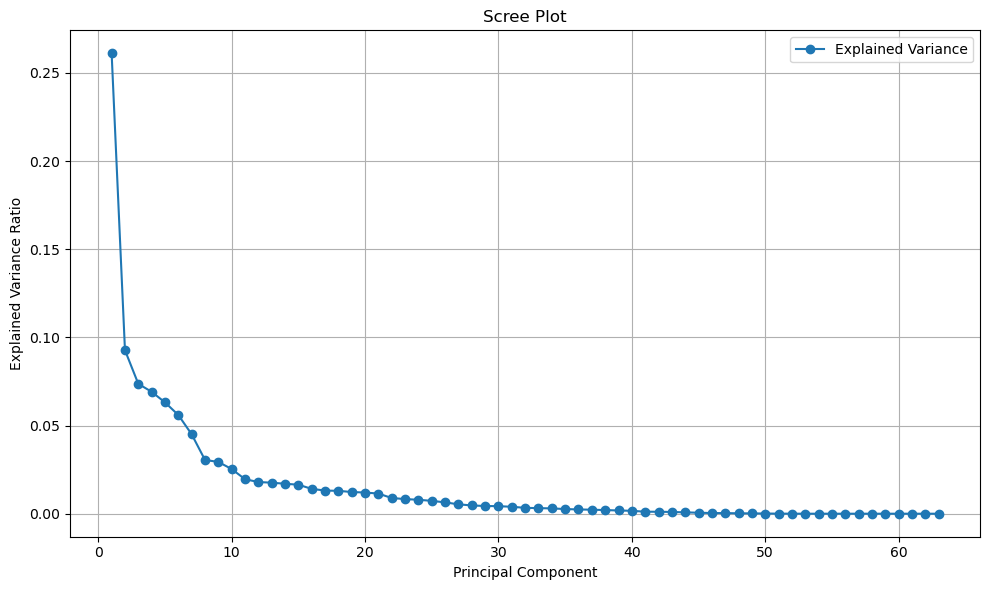

In [50]:
# Create a scree plot
plt.figure(figsize=(10,6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, 'o-', label='Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save scree plot
plt.savefig("scree_plot_experiment5.png")


# Display the scree plot on screen
plt.show()


plt.close()

In [51]:
# Decide number of components:
# e.g., choose number of components that explain ~90% variance
cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print("Number of components selected:", n_components)

# Create final pipeline with PCA and XGBoost
pipeline = Pipeline([
    ("feature_engineering", fe_transformer),
    ("preprocessing", preprocessing),
    ("pca", PCA(n_components=n_components, random_state=42)),
    ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
])

f1_scorer = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_scores = cross_val_score(pipeline, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

f1_train = f1_score(y_train, y_pred_train, pos_label=1)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)

cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("Experiment #5: PCA + XGBoost")
print("CV Mean F1:", mean_f1, "CV Std F1:", std_f1)
print("Train F1:", f1_train)
print("Test F1:", f1_test)
print("Confusion Matrix:\n", cm)

Number of components selected: 21


Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x31375b600>)),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Duration',
                                                   'Campaign', 'Pdays',
                                                   'Previous', 'EmpVarRate',
                                                   'ConsPriceIdx',
                                                   'ConsConfIdx', 'Eur...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Experiment #5: PCA + XGBoost
CV Mean F1: 0.47993310024566577 CV Std F1: 0.05554666807208669
Train F1: 1.0
Test F1: 0.410958904109589
Confusion Matrix:
 [[708  26]
 [ 60  30]]


In [52]:
# Logging to MLflow on DagsHub

from mlflow.models import infer_signature
signature = infer_signature(X_train, pipeline.predict(X_train))

MLFLOW_TRACKING_URI = "https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saisampath1107'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '25c1ff81e89787fad89c11d841ea27b3c8523320'

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("BankMarketing_Experiment5")

with mlflow.start_run(run_name="XGB_with_PCA"):
    mlflow.log_param("model_type", "XGBClassifier_with_PCA")
    mlflow.log_param("n_components", n_components)

    # Log CV metrics
    mlflow.log_metric("cv_mean_f1", mean_f1)
    mlflow.log_metric("cv_std_f1", std_f1)

    # Log train/test metrics
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)

    # Confusion matrix elements
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Log the model
    mlflow.sklearn.log_model(pipeline, "model", signature=signature)
    
    # Log the scree plot as an artifact
    mlflow.log_artifact("scree_plot_experiment5.png")

print("Experiment #5 completed. Results and scree plot logged to MLflow on DagsHub.")

/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


<Experiment: artifact_location='mlflow-artifacts:/07948dde449d467fb25011b15fd295ee', creation_time=1734674003111, experiment_id='4', last_update_time=1734674003111, lifecycle_stage='active', name='BankMarketing_Experiment5', tags={}>

'XGBClassifier_with_PCA'

21

🏃 View run XGB_with_PCA at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/4/runs/6cb6573b713e463491815124fd465a14
🧪 View experiment at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/4
Experiment #5 completed. Results and scree plot logged to MLflow on DagsHub.


# Experiment #6: Design and execute a custom experiment. Log results in MLFlow.

In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import mlflow
import mlflow.sklearn
import os

In [54]:
# Experiment #6: Custom Experiment

# Approach:
# 1. Use the best pipeline from a previous experiment (e.g., from Experiment #3 or #4) for XGBoost.
# 2. Create another pipeline with Logistic Regression.
# 3. Instead of picking just one, combine their predicted probabilities (ensembling) to form final predictions.
# 4. Evaluate the ensemble and log results to MLflow.

def feature_engineering(X_df):
    """Feature Engineering as before."""
    X_df = X_df.copy()
    X_df['was_previously_contacted'] = (X_df['Pdays'] != 999).astype(int)
    X_df['calls_per_previous_campaign'] = X_df['Campaign'] / (X_df['Previous'] + 1)
    return X_df

fe_transformer = FunctionTransformer(feature_engineering, validate=False)


In [55]:
# Identify numeric/categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features)
])

# Define pipelines for both models
xgb_pipeline = Pipeline([
    ("feature_engineering", fe_transformer),
    ("preprocessing", preprocessing),
    ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
])

lr_pipeline = Pipeline([
    ("feature_engineering", fe_transformer),
    ("preprocessing", preprocessing),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

f1_scorer = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [56]:
# Evaluate each pipeline separately via cross-validation
xgb_scores = cross_val_score(xgb_pipeline, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)
lr_scores = cross_val_score(lr_pipeline, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)

print("=== Experiment #6: Custom Ensemble (XGB + LR) ===")
print("XGB CV Mean F1:", np.mean(xgb_scores))
print("LR CV Mean F1:", np.mean(lr_scores))

=== Experiment #6: Custom Ensemble (XGB + LR) ===
XGB CV Mean F1: 0.5411621363122119
LR CV Mean F1: 0.5147912429565655


In [57]:
# Fit both pipelines on entire training set
xgb_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x3133a8e00>)),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Duration',
                                                   'Campaign', 'Pdays',
                                                   'Previous', 'EmpVarRate',
                                                   'ConsPriceIdx',
                                                   'ConsConfIdx', 'Eur...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x3133a8e00>)),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Duration',
                                                   'Campaign', 'Pdays',
                                                   'Previous', 'EmpVarRate',
                                                   'ConsPriceIdx',
                                                   'ConsConfIdx', 'Euribor3m',
                                                   'NrEmployed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Job', 'Marital_Status',
                                                   'Education',
                                                   'Default_Status', 'Housing',
                                                   'Loan', 'Contact', 'Month',
                                                   'DayOfWeek',
                                                   'Poutcome'])])),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

In [58]:
# Ensemble Prediction:
# Get predicted probabilities from both models, average them, then threshold at 0.5 for final classification
xgb_proba = xgb_pipeline.predict_proba(X_test)[:,1]
lr_proba = lr_pipeline.predict_proba(X_test)[:,1]

ensemble_proba = (xgb_proba + lr_proba) / 2.0
y_pred_ensemble = (ensemble_proba >= 0.5).astype(int)

# Evaluate ensemble
f1_test = f1_score(y_test, y_pred_ensemble, pos_label=1)
f1_train = None  # If needed, we can also evaluate on train set similarly by predictions on train
# For demonstration, let's do that:
xgb_train_proba = xgb_pipeline.predict_proba(X_train)[:,1]
lr_train_proba = lr_pipeline.predict_proba(X_train)[:,1]
ensemble_train_proba = (xgb_train_proba + lr_train_proba) / 2.0
y_pred_ensemble_train = (ensemble_train_proba >= 0.5).astype(int)
f1_train = f1_score(y_train, y_pred_ensemble_train, pos_label=1)

cm = confusion_matrix(y_test, y_pred_ensemble, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("Train F1:", f1_train)
print("Test F1:", f1_test)
print("Confusion Matrix:\n", cm)

Train F1: 0.9013254786450663
Test F1: 0.5324675324675324
Confusion Matrix:
 [[711  23]
 [ 49  41]]


In [59]:
# Set MLflow tracking URI and experiment
MLFLOW_TRACKING_URI = "https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saisampath1107'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '25c1ff81e89787fad89c11d841ea27b3c8523320'

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("BankMarketing_Experiment6")

with mlflow.start_run(run_name="XGB_LR_Ensemble"):
    mlflow.log_param("model_type_1", "XGBClassifier")
    mlflow.log_param("model_type_2", "LogisticRegression")
    mlflow.log_param("ensemble_method", "average_proba")

    # Log CV results of individual models
    mlflow.log_metric("xgb_cv_mean_f1", np.mean(xgb_scores))
    mlflow.log_metric("lr_cv_mean_f1", np.mean(lr_scores))

    # Log ensemble final metrics
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)

    # Confusion matrix elements
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Save pipelines as artifacts
    import joblib
    joblib.dump(xgb_pipeline, "xgb_pipeline.pkl")
    joblib.dump(lr_pipeline, "lr_pipeline.pkl")
    mlflow.log_artifact("xgb_pipeline.pkl")
    mlflow.log_artifact("lr_pipeline.pkl")

    # Additional documentation
    with open("experiment6_description.txt", "w") as f:
        f.write("Custom ensemble experiment: averaging predicted probabilities of XGB and LR.")
    mlflow.log_artifact("experiment6_description.txt")

print("Experiment #6 completed. Results have been printed above and also logged to MLflow on DagsHub.")

<Experiment: artifact_location='mlflow-artifacts:/66275dcc57134d028d2d0a6202487dad', creation_time=1734674362875, experiment_id='5', last_update_time=1734674362875, lifecycle_stage='active', name='BankMarketing_Experiment6', tags={}>

'XGBClassifier'

'LogisticRegression'

'average_proba'

['xgb_pipeline.pkl']

['lr_pipeline.pkl']

76

🏃 View run XGB_LR_Ensemble at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/5/runs/aa998870e8bc4d77a4c350a4a094c6d5
🧪 View experiment at: https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow/#/experiments/5
Experiment #6 completed. Results have been printed above and also logged to MLflow on DagsHub.


# Experiment #7: Design and execute another custom experiment. Log results in MLFlow.

In [60]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from xgboost import XGBClassifier

import mlflow
import mlflow.sklearn
import joblib

# ===== IMPORT YOUR CUSTOM FEATURE FUNCTION HERE =====
from custom_features import feature_engineering

# Suppose you have X_train, y_train, X_test, y_test already loaded in memory
# (You’d have done something like: X_train, X_test, y_train, y_test = train_test_split(...))

# Step 1: Create a FunctionTransformer with the external function
fe_transformer = FunctionTransformer(feature_engineering, validate=False)

# Step 2: Separate numeric vs. categorical columns
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=[object]).columns.tolist()

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

# Combine into a ColumnTransformer
preprocessing = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features)
])

# Step 3: Build final pipeline
pipeline = Pipeline([
    ("feature_engineering", fe_transformer),
    ("preprocessing", preprocessing),
    ("clf", XGBClassifier(eval_metric='logloss', random_state=42))
])

# Step 4: Cross-validation
f1_scorer = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = cross_val_score(pipeline, X_train, y_train, scoring=f1_scorer, cv=cv, n_jobs=-1)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Step 5: Fit on full training set
pipeline.fit(X_train, y_train)

# Step 6: Probability predictions on training
train_proba = pipeline.predict_proba(X_train)[:, 1]

# Step 7: Tune threshold on training set
thresholds = np.arange(0.0, 1.01, 0.01)
best_threshold = 0.5
best_f1_train = -1

for thresh in thresholds:
    y_pred_thresh = (train_proba >= thresh).astype(int)
    f1_t = f1_score(y_train, y_pred_thresh, pos_label=1)
    if f1_t > best_f1_train:
        best_f1_train = f1_t
        best_threshold = thresh

# Evaluate with best_threshold on test set
test_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (test_proba >= best_threshold).astype(int)
f1_test = f1_score(y_test, y_pred_test, pos_label=1)

# Evaluate on train set with best_threshold
y_pred_train = (train_proba >= best_threshold).astype(int)
f1_train = f1_score(y_train, y_pred_train, pos_label=1)

cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("=== Experiment #7: Threshold Tuning ===")
print("CV Mean F1:", mean_f1, "CV Std F1:", std_f1)
print("Best threshold on training data:", best_threshold)
print("Train F1 with best threshold:", f1_train)
print("Test F1 with best threshold:", f1_test)
print("Confusion Matrix:\n", cm)

# Optional: log to MLflow
from mlflow.models import infer_signature
signature = infer_signature(X_train, y_pred_train)

MLFLOW_TRACKING_URI = "https://dagshub.com/saisampath1107/EAS_503_Term_Deposit_Classification.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'saisampath1107'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '25c1ff81e89787fad89c11d841ea27b3c8523320'

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("BankMarketing_Experiment7")

with mlflow.start_run(run_name="XGB_with_Threshold_Tuning"):
    mlflow.log_param("model_type", "XGBClassifier")
    mlflow.log_param("threshold_tuning", True)

    mlflow.log_metric("cv_mean_f1", mean_f1)
    mlflow.log_metric("cv_std_f1", std_f1)
    mlflow.log_metric("best_threshold", best_threshold)
    mlflow.log_metric("f1_train", f1_train)
    mlflow.log_metric("f1_test", f1_test)
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Save pipeline and threshold info
    joblib.dump(pipeline, "xgb_pipeline_expt7.pkl")
    with open("threshold_expt7.txt", "w") as f:
        f.write(f"Best threshold: {best_threshold}\n")

    mlflow.log_artifact("xgb_pipeline_expt7.pkl")
    mlflow.log_artifact("threshold_expt7.txt")

print("Experiment #7 completed. Threshold tuning results displayed and logged to MLflow.")



# Create meaningful F1-score plots to compare experiments and determine the best model.

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 7 artists>

<BarContainer object of 7 artists>

Text(0.5, 0, 'Experiment Number')

Text(0, 0.5, 'F1-score')

Text(0.5, 1.0, 'Comparison of F1-scores Across Experiments 1-7')

([<matplotlib.axis.XTick at 0x3133ba930>,
 [Text(0.175, 0, '1'),
  Text(1.175, 0, '2'),
  Text(2.175, 0, '3'),
  Text(3.175, 0, '4'),
  Text(4.175, 0, '5'),
  Text(5.175, 0, '6'),
  Text(6.175, 0, '7')])

Text(6.35, 0.5924175824175825, 'Best: Exp 7\nF1=0.582')

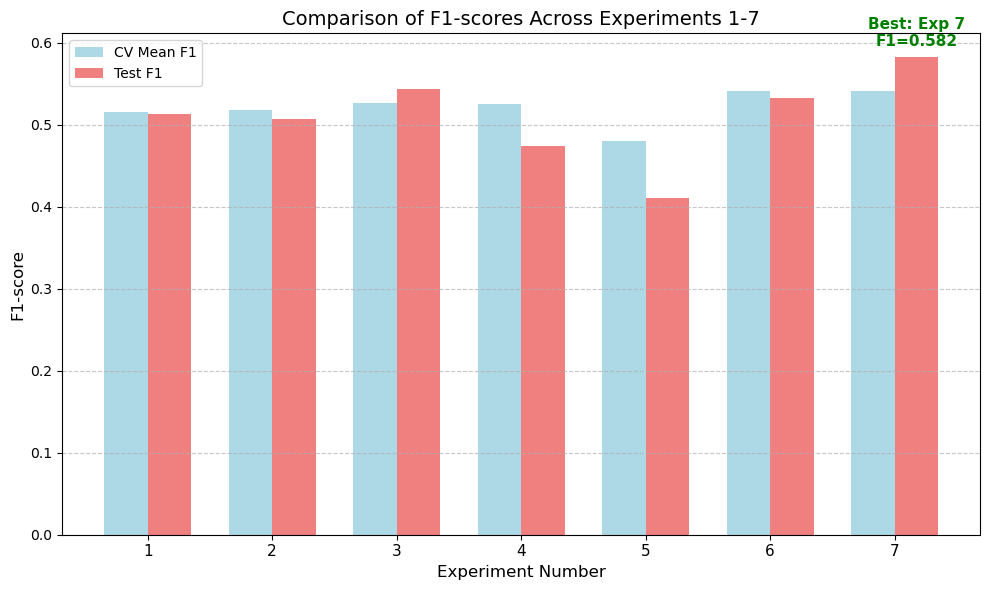

<Figure size 640x480 with 0 Axes>

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Actual values from your results (as previously provided):
cv_mean_f1_scores = [
    0.5155588627594773,  # Exp 1
    0.5178837728723588,  # Exp 2
    0.5268411227992448,  # Exp 3
    0.5253334665895026,  # Exp 4
    0.47993310024566577, # Exp 5
    0.5411621363122119,  # Exp 6
    0.5411621363122119   # Exp 7
]

test_f1_scores = [
    0.5135135135135135,  # Exp 1
    0.5068493150684932,  # Exp 2
    0.5432098765432098,  # Exp 3
    0.47435897435897434, # Exp 4
    0.410958904109589,   # Exp 5
    0.5324675324675324,  # Exp 6
    0.5824175824175825   # Exp 7
]

experiments = np.arange(1, 8)  # Experiments 1 through 7

plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(experiments))

# Use pastel colors
cv_color = "lightblue"
test_color = "lightcoral"

# Plot CV mean F1-scores
plt.bar(index, cv_mean_f1_scores, bar_width, label='CV Mean F1', color=cv_color)

# Plot Test F1-scores next to CV scores
plt.bar(index + bar_width, test_f1_scores, bar_width, label='Test F1', color=test_color)

plt.xlabel('Experiment Number', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.title('Comparison of F1-scores Across Experiments 1-7', fontsize=14)
plt.xticks(index + bar_width/2, experiments, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend()

# Annotate the best model based on Test F1-score
best_idx = np.argmax(test_f1_scores)
best_experiment = experiments[best_idx]
best_score = test_f1_scores[best_idx]
plt.text(best_idx + bar_width, best_score + 0.01,
         f'Best: Exp {best_experiment}\nF1={best_score:.3f}',
         ha='center', va='bottom', color='green', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig("experiment_f1_scores_comparison.png")

# Save the final model using joblib

In [67]:
import joblib

joblib.dump(pipeline, "final_model_experiment_7.pkl")
print("Model saved as final_model_experiment_7.pkl")

['final_model_experiment_7.pkl']

Model saved as final_model_experiment_7.pkl


In [68]:
import joblib
import pandas as pd

# 1. Load your final pipeline + threshold
final_pipeline_expt7 = joblib.load("final_model_experiment_7.pkl")

In [69]:
best_threshold = 0.27

# 2. Create a sample row
sample_data = {
    "Age": [30],
    "Job": ["blue-collar"],
    "Marital_Status": ["married"],
    "Education": ["basic.9y"],
    "Default_Status": ["no"],
    "Housing": ["yes"],
    "Loan": ["no"],
    "Contact": ["cellular"],
    "Month": ["may"],
    "DayOfWeek": ["fri"],
    "Duration": [487],
    "Campaign": [2],
    "Pdays": [999],
    "Previous": [0],
    "Poutcome": ["nonexistent"],
    "EmpVarRate": [-1.8],
    "ConsPriceIdx": [92.893],
    "ConsConfIdx": [-46.2],
    "Euribor3m": [1.313],
    "NrEmployed": [5099.1]
}
sample_df = pd.DataFrame(sample_data)

# 3. Predict probabilities
probas = final_pipeline_expt7.predict_proba(sample_df)
pos_class_proba = probas[:, 1]

# 4. Compare to custom threshold
pred_binary = (pos_class_proba >= best_threshold).astype(int)
print("Predicted Binary (0=no, 1=yes):", pred_binary)

# If your final training used string labels, map them
map_class = {0: "no", 1: "yes"}
predicted_labels = [map_class[p] for p in pred_binary]
print("Custom threshold label:", predicted_labels)

print(f"Probability for 'yes' class = {pos_class_proba[0]:.3f}")
print(f"Threshold used = {best_threshold}")

Predicted Binary (0=no, 1=yes): [0]
Custom threshold label: ['no']
Probability for 'yes' class = 0.103
Threshold used = 0.27


In [70]:
best_threshold = 0.27

# 2. Create a sample row
sample_data = {
    "Age": [39],
    "Job": ["services"],
    "Marital_Status": ["single"],
    "Education": ["high.school"],
    "Default_Status": ["no"],
    "Housing": ["no"],
    "Loan": ["no"],
    "Contact": ["telephone "],
    "Month": ["may"],
    "DayOfWeek": ["fri"],
    "Duration": [346],
    "Campaign": [4],
    "Pdays": [999],
    "Previous": [0],
    "Poutcome": ["nonexistent"],
    "EmpVarRate": [1.1],
    "ConsPriceIdx": [93.994],
    "ConsConfIdx": [-36.4],
    "Euribor3m": [4.855],
    "NrEmployed": [5191]
}
sample_df = pd.DataFrame(sample_data)

# 3. Predict probabilities
probas = final_pipeline_expt7.predict_proba(sample_df)
pos_class_proba = probas[:, 1]

# 4. Compare to custom threshold
pred_binary = (pos_class_proba >= best_threshold).astype(int)
print("Predicted Binary (0=no, 1=yes):", pred_binary)

# If your final training used string labels, map them
map_class = {0: "no", 1: "yes"}
predicted_labels = [map_class[p] for p in pred_binary]
print("Custom threshold label:", predicted_labels)

print(f"Probability for 'yes' class = {pos_class_proba[0]:.3f}")
print(f"Threshold used = {best_threshold}")

Predicted Binary (0=no, 1=yes): [0]
Custom threshold label: ['no']
Probability for 'yes' class = 0.014
Threshold used = 0.27
